# Baseline model

This notebook contains the model that we will use as a baseline to compare all others. The architecture we will deploy is a simple CNN. This model will be trained and tested over partitions of the the COCO 2014 training dataset. 

## Libraries import

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from skimage import color
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim

## Data import

We build a class to import the dataset and handle the COCO images in the desired formats.

In [2]:
class CocoDataset(Dataset):
    def __init__(self, root, transform = None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if f.endswith('.jpg')]
        if not self.image_paths:
            raise ValueError("No images found in the directory. Check the directory path.")
        print(f"Found {len(self.image_paths)} images.")
        

    def __len__(self):
        return len(self.image_paths)
    

    def __getitem__(self, index):
        try:
            image_path = self.image_paths[index]
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            image_np = np.array(image.permute(1, 2, 0))
            lab_image = rgb2lab(image_np)
            l_channel = torch.from_numpy(lab_image[:, :, 0] / 100).unsqueeze(0).float()
            ab_channels = torch.from_numpy(lab_image[:, :, 1:] / 128).permute(2, 0, 1).float()
            return image, l_channel, ab_channels
        except Exception as e:
            print(f"Error processing index {index}: {e}")
            raise

    def get_channels_for_image(self, index):
        # Directly use the output from __getitem__
        _, l_channel, ab_channels = self.__getitem__(index)
        # Directly return the already computed L, A, B, and AB channels
        a_channel = ab_channels[0, :, :]  # Assuming A is the first channel in AB tensor
        b_channel = ab_channels[1, :, :]  # Assuming B is the second channel in AB tensor
        return l_channel, a_channel, b_channel, ab_channels
        
    def plot_l(self, index):
        _, l_channel, _ = self[index]  # Unpack to get the L channel
        l_channel = l_channel.squeeze()  # Remove unnecessary dimension
        plt.figure(figsize=(6, 6))
        plt.imshow(l_channel, cmap='gray')
        plt.axis('off')
        plt.show()

    def plot_a(self, index):
        _, a_channel, _, _ = self.get_channels_for_image(index)
        plt.figure(figsize=(6, 6))
        plt.imshow(a_channel, cmap='coolwarm')
        plt.axis('off')
        plt.show()

    def plot_b(self, index):
        _, _, b_channel, _ = self.get_channels_for_image(index)
        plt.figure(figsize=(6, 6))
        plt.imshow(b_channel, cmap='coolwarm')
        plt.axis('off')
        plt.show()
    
    def plot_ab(self, index, l_values=[25, 50, 75]):
        _, _, _, ab_channels = self.get_channels_for_image(index)  # Extract the AB channels from the dataset
        
        # Ensure AB channels are in the correct shape (256, 256, 2)
        if ab_channels.shape[0] == 2:  # Assuming ab_channels shape is initially (2, 256, 256)
            ab_channels = ab_channels.permute(1, 2, 0)  # Change to (256, 256, 2)
        
        for l in l_values:
            lab_image = np.zeros((ab_channels.shape[0], ab_channels.shape[1], 3))
            lab_image[:, :, 0] = l  # Set the L channel to one of the specified L values
            lab_image[:, :, 1:] = ab_channels * 128 - 128  # Scale AB channels correctly for lab2rgb
            
            rgb_image = lab2rgb(lab_image)
            
            plt.figure(figsize=(6, 6))
            plt.imshow(rgb_image)
            plt.title(f'L = {l}')
            plt.axis('off')
            plt.show()
    
    def plot_rgb(self, index):
        rgb_image, _, _ = self[index]  # Unpacking to get the RGB image
        rgb_image = rgb_image.permute(1, 2, 0)  # Convert from CxHxW to HxWxC for plotting
        plt.figure(figsize=(6, 6))
        plt.imshow(rgb_image)
        plt.axis('off')
        plt.show()

Resize the images and convert them into tensors.

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to a fixed size
    transforms.ToTensor(),  # Convert the image to a tensor
])

Import the dataset.

In [4]:
dataset = CocoDataset(root='C:/Users/diego/coco/images/train2014/train2014', transform=transform)

Found 82783 images.


Observe the dataset size.

In [5]:
image, l_channel, ab_channel = dataset[0]
print(f"Number of images: {len(dataset)}\n L channel shape: {l_channel.shape}\n AB channel shape:{ab_channel.shape}")

Number of images: 82783
 L channel shape: torch.Size([1, 64, 64])
 AB channel shape:torch.Size([2, 64, 64])


Let's look at the first image in the dataset.

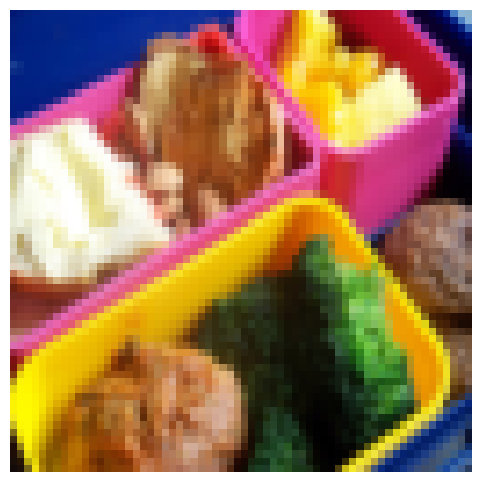

In [6]:
dataset.plot_rgb(0)

Let's convert this image in a black-and-white format using a previously defined function.

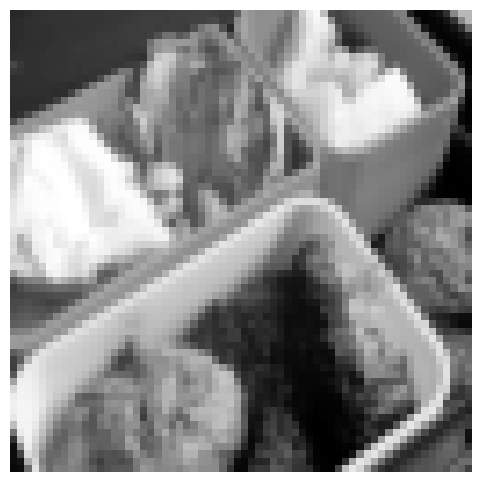

In [7]:
dataset.plot_l(0)

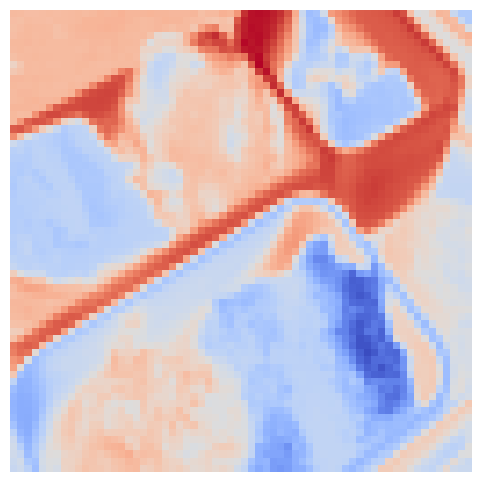

In [8]:
dataset.plot_a(0)

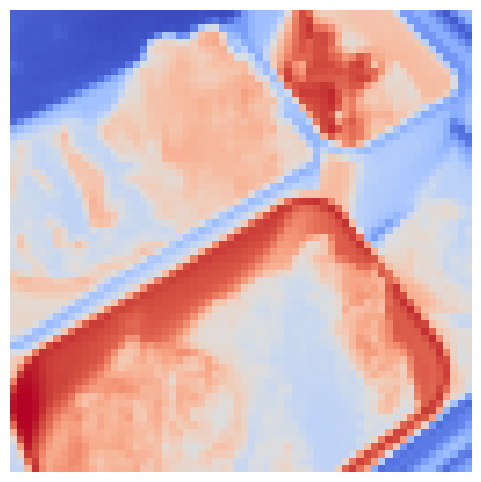

In [9]:
dataset.plot_b(0)

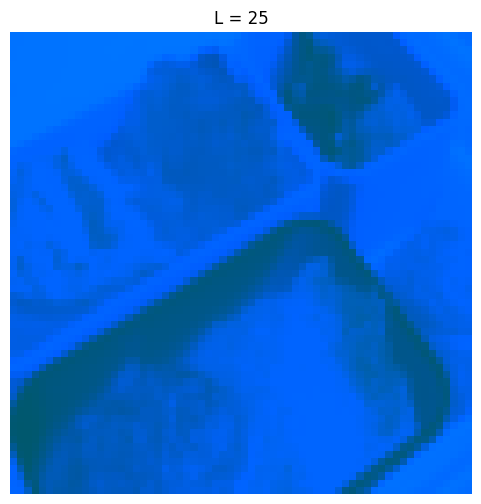

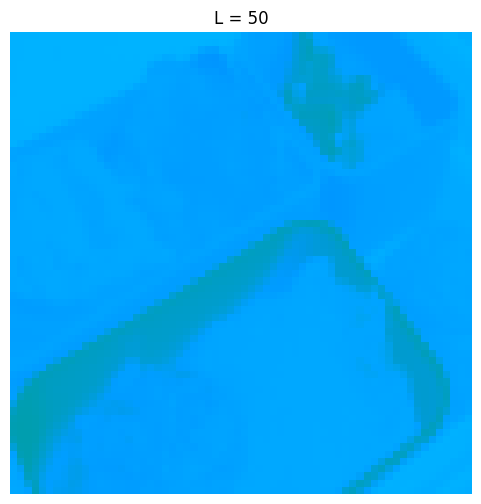

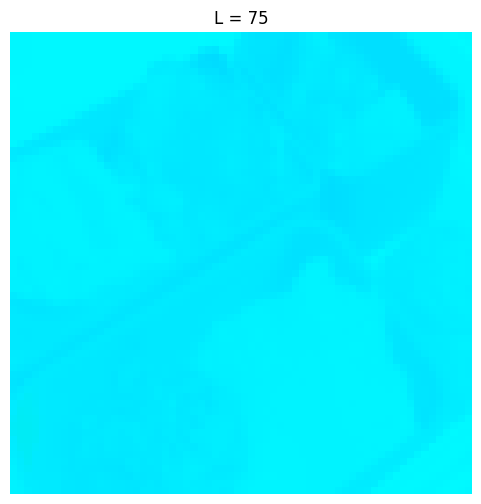

In [10]:
dataset.plot_ab(0)

We build a function that will later turn useful: given an L channel, and an AB channel, we reconstruct the original image

In [11]:
def reconstruct_lab(l, ab):
    if l.shape == torch.Size([1, 256, 256]):
        l = l.squeeze(0)
    a = ab[0]
    b = ab[1]
    lab_image = torch.stack((l, a, b), dim=0)

    lab_image_np = lab_image.permute(1, 2, 0).cpu().numpy()

    # Denormalize LAB channels
    l_channel = lab_image_np[:, :, 0] * 100  # Revert L channel normalization
    ab_channels = lab_image_np[:, :, 1:] * 128  # Revert A and B channel normalization

    # Stack L, A, B channels
    lab_image_reconstructed = np.zeros((lab_image_np.shape[0], lab_image_np.shape[1], 3))
    lab_image_reconstructed[:, :, 0] = l_channel
    lab_image_reconstructed[:, :, 1:] = ab_channels

    # Convert LAB image to RGB
    rgb_image = lab2rgb(lab_image_reconstructed)

    # Display the RGB image
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

## Data preparation

We split our dataset in train and test data.

In [12]:
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size

In [13]:
train, test = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test, batch_size=64, shuffle=True, num_workers=4)

## CNN Model

For the moment, we will work with a small subset of the training data

In [14]:
train_size = 8000
small_train, _ = random_split(train, [train_size, len(train) - train_size])
small_train_loader = DataLoader(small_train, batch_size=16, shuffle=True, num_workers=0)

In [15]:
class ColorizationCNN(nn.Module):
    def __init__(self):
        super(ColorizationCNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(32, 2, kernel_size=3, padding=1)
        # Define upsampling layers
        self.upsample = nn.Upsample(scale_factor=1, mode='bilinear', align_corners=False)
        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        # Upsample to increase resolution of output
        x = self.upsample(x)
        return x

## Training

In [16]:
model = ColorizationCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    # Wrap your data loader with tqdm for a progress bar
    progress_bar = tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True)
    i = 1
    for _, l_channels, ab_channels in progress_bar:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(l_channels)  # Forward pass
        loss = criterion(outputs, ab_channels)  # Compute the loss
        loss.backward()  # Backward pass and optimization
        optimizer.step()

        # Update running loss and display on tqdm progress bar
        running_loss += loss.item()
        progress_bar.set_postfix(loss=(running_loss / (progress_bar.n + 1)))
        i+=1

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(small_train_loader)}")

print('Finished Training')

Epoch 1/10:   0%|          | 0/500 [00:00<?, ?it/s]

progress bar loaded


Epoch 1/10: 100%|██████████| 500/500 [30:33<00:00,  3.67s/it, loss=0.0138] 


Epoch 1, Loss: 0.013793759752996265


Epoch 2/10:   0%|          | 0/500 [00:00<?, ?it/s]

progress bar loaded


Epoch 2/10: 100%|██████████| 500/500 [28:26<00:00,  3.41s/it, loss=0.0138]


Epoch 2, Loss: 0.013793759759515524


Epoch 3/10:   0%|          | 0/500 [00:00<?, ?it/s]

progress bar loaded


Epoch 3/10: 100%|██████████| 500/500 [28:18<00:00,  3.40s/it, loss=0.0138]


Epoch 3, Loss: 0.013793759757652879


Epoch 4/10:   0%|          | 0/500 [00:00<?, ?it/s]

progress bar loaded


Epoch 4/10: 100%|██████████| 500/500 [27:09<00:00,  3.26s/it, loss=0.0138]


Epoch 4, Loss: 0.013793759756721556


Epoch 5/10:   0%|          | 0/500 [00:00<?, ?it/s]

progress bar loaded


Epoch 5/10:  53%|█████▎    | 265/500 [14:34<16:53,  4.31s/it, loss=0.0138] 

## Testing

In [ ]:
model.eval()

In [ ]:
total_mse_loss = 0
with torch.no_grad():
    for inputs, _, ab_channels_gt in tqdm(test_loader, desc='Evaluating', leave=True):
        outputs = model(inputs)
        mse_loss = criterion(outputs, ab_channels_gt)
        total_mse_loss += mse_loss.item()

average_mse_loss = total_mse_loss / len(test_loader)
print(f"Average MSE Loss: {average_mse_loss:.4f}")